# MiniRun6 LRS tutorial 5

In [116]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ../h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing /global/u1/j/jvmead/dune/h5flow
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31716 sha256=125c4b5071228bc1544a61abd6f195fce9037e016708236a0ea746718f93aa0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_55nwj3a/wheels/f1/5d/58/77983378fc64f41b62b695d5a44d952fa4c38d69af5c3ba1f2
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [117]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)

fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [118]:
max_events = 100
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0

sipm_hits = f['light/sipm_hits/data']

n_samples = light_wvfms.shape[-1]
bin_width_ns = 16.0  # ns
time_bins = np.arange(0, n_samples, 1)*bin_width_ns

In [119]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

In [120]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light.assertwvfm_noise_filter
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/hit_finder.py#L189-L231
from scipy.ndimage import uniform_filter1d

def peak_finder(#self,
                wvfm, noise,
                n_noise_factor = 5,
                n_bins_rolled = 5,
                n_sqrt_rt_factor = 3,
                pe_weight = 0.12,
                use_rising_edge=False,
                use_local_maxima=True):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])
    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)
    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]
    if use_rising_edge:
        return first_bins_over
    # Peak finding
    elif use_local_maxima:
        # check 5 bins after first_bins_over and add argmax
        peak_bins = np.zeros_like(wvfm, dtype=bool)
        first_bins_indices = np.where(first_bins_over)
        for idx in zip(*first_bins_indices):
            start_idx = idx[-1]
            end_idx = min(start_idx + 5, wvfm.shape[-1])
            peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
            peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    else:
        # Derivative-based peak detection
        wvfm_d1 = np.gradient(wvfm, axis=-1)
        wvfm_d2 = np.gradient(wvfm_d1, axis=-1)
        peak_bins = (wvfm > dynamic_threshold) & (wvfm > height) & \
            (wvfm_d1 < 0) & (wvfm_d2 < 0)
        # Keep only the first peak in consecutive runs
        peak_bins[..., 1:] &= ~peak_bins[..., :-1]

    return peak_bins

In [121]:
baselines, rms = min_range_baseline(light_wvfms)
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]
sipm_hits = peak_finder(wvfm=cwvfms, noise=rms_calib, n_noise_factor=5,
                        n_bins_rolled=5, n_sqrt_rt_factor=5, pe_weight=1.0)

Summing channels!

In [122]:
# these are generated in lrs_sanity_check/channel_sum_masks/ from the yaml file in proto_nd_flow

# import channel masks from npy files
ttype_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_TrapType.npy')
print(ttype_sum.shape)

# example: for ttype 10, print channel indices (det_index, channel_index) and flattened indices
ttype = 10
indices = np.argwhere(ttype_sum[ttype])
print(f"TrapType {ttype}:")
for idx in indices:
    print(f"ADC {idx[0]} Channel {idx[1]}")

(16, 8, 64)
TrapType 10:
ADC 4 Channel 4
ADC 4 Channel 5
ADC 4 Channel 6
ADC 4 Channel 7
ADC 4 Channel 8
ADC 4 Channel 9
ADC 4 Channel 10
ADC 4 Channel 11
ADC 4 Channel 12
ADC 4 Channel 13
ADC 4 Channel 14
ADC 4 Channel 15
ADC 4 Channel 20
ADC 4 Channel 21
ADC 4 Channel 22
ADC 4 Channel 23
ADC 4 Channel 24
ADC 4 Channel 25
ADC 4 Channel 26
ADC 4 Channel 27
ADC 4 Channel 28
ADC 4 Channel 29
ADC 4 Channel 30
ADC 4 Channel 31


In [123]:
# sum the channels wvfms and rms by the DET masks
ttype_wvfms = np.zeros((light_wvfms.shape[0], ttype_sum.shape[0], light_wvfms.shape[3]))
ttype_rms = np.zeros((light_wvfms.shape[0], ttype_sum.shape[0]))
for i in range(ttype_sum.shape[0]):
    mask = ttype_sum[i] != 0
    ttype_wvfms[:, i, :] = np.sum(cwvfms[:, mask, :], axis=1)
    ttype_rms[:, i] = np.sqrt(np.sum(rms_calib[:, mask]**2, axis=1))
print(ttype_wvfms.shape)
print(ttype_rms.shape)

ttype_hits = peak_finder(wvfm=ttype_wvfms, noise=ttype_rms)
print(ttype_hits.shape)

(101, 16, 1000)
(101, 16)
(101, 16, 1000)


In [124]:
def plot_waveform_with_hit_finder(wvfms, hits_list,
                                  labels=None, title=None,
                                  sample_size_ns=16):
    # ensure arrays of waveforms
    wvfms = np.atleast_2d(wvfms)
    # normalize hits_list to list of index arrays
    if hits_list is None:
        hits_list = [np.array([], dtype=int)] * wvfms.shape[0]
    else:
        # if single hits array provided for multiple waveforms, broadcast it
        if not hasattr(hits_list, '__len__') or (isinstance(hits_list, np.ndarray) and hits_list.ndim == 1 and wvfms.shape[0] > 1):
            hits_list = [hits_list] * wvfms.shape[0]
        hits_list = list(hits_list)

    plt.figure(figsize=(10, 3))
    cmap = plt.get_cmap('tab10')
    max_len = max(len(w) for w in wvfms)

    for i, (wvfm, hits) in enumerate(zip(wvfms, hits_list)):
        color = cmap(i % cmap.N)
        x = np.arange(len(wvfm))
        if sample_size_ns != 1 and sample_size_ns is not None:
            x = x * sample_size_ns  # convert to ns
        label = labels[i] if labels is not None and i < len(labels) else f'waveform {i}'
        plt.plot(x, wvfm, color=color, label=label)

        # convert boolean mask or iterable to indices
        if hits is None:
            hit_idx = np.array([], dtype=int)
        elif isinstance(hits, np.ndarray) and hits.dtype == bool:
            hit_idx = np.where(hits)[0]
        else:
            try:
                hit_idx = np.asarray(hits, dtype=int)
            except Exception:
                hit_idx = np.array([], dtype=int)

        if hit_idx.size > 0:
            hit_times = hit_idx * (sample_size_ns if sample_size_ns is not None else 1)
            plt.scatter(hit_times, wvfm[hit_idx], color=color, edgecolor='k',
                        s=40, zorder=3, label=f'hits {i}')

    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Sample index' if sample_size_ns is None else 'Time (ns)')
    plt.ylabel('PE/sample')
    plt.xlim(0, max_len * (sample_size_ns if sample_size_ns is not None else 1))

    # show legend if entries exist
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend(ncol=2, fontsize='small')
    if title is not None:
        plt.title(title)
    plt.show()

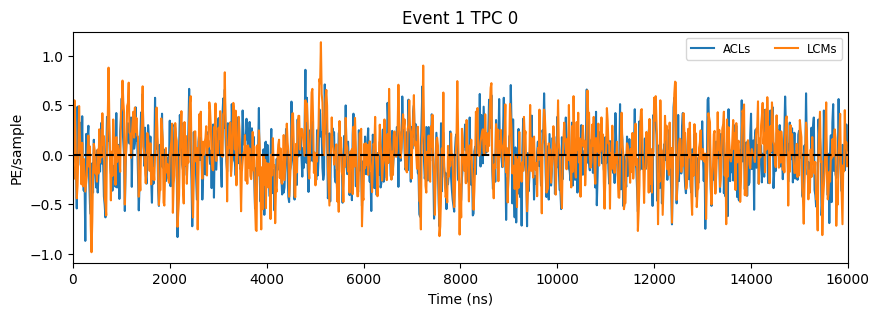

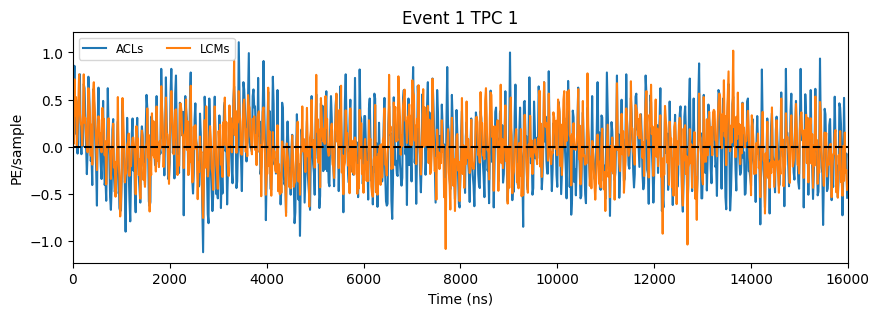

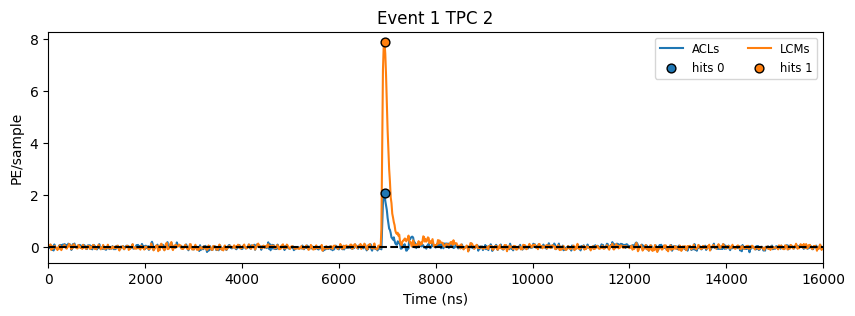

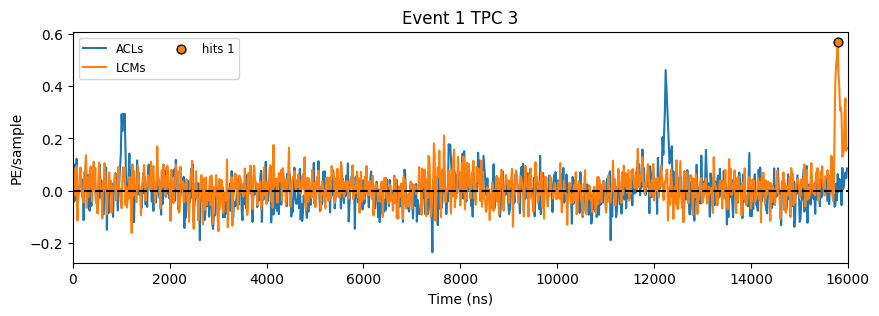

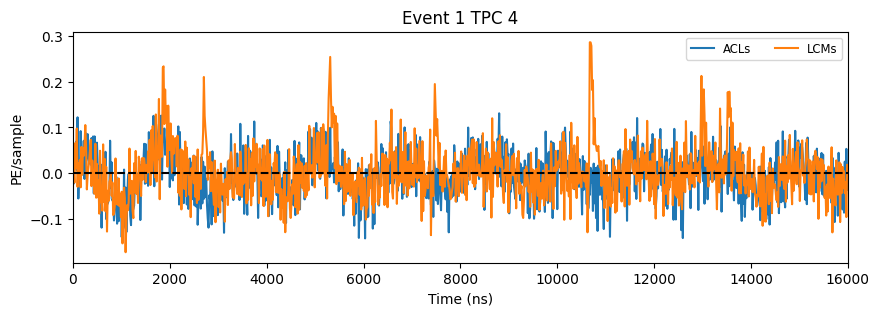

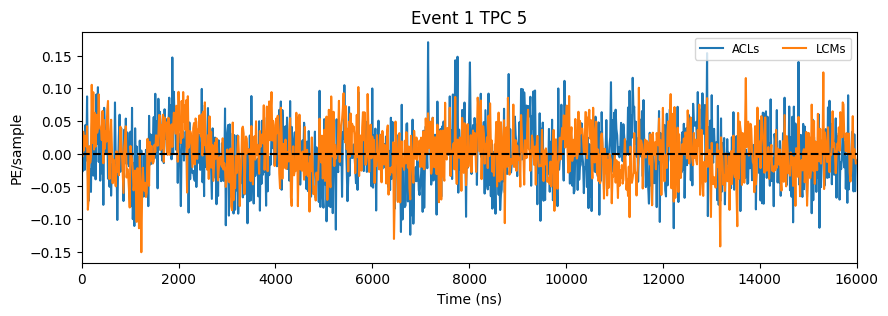

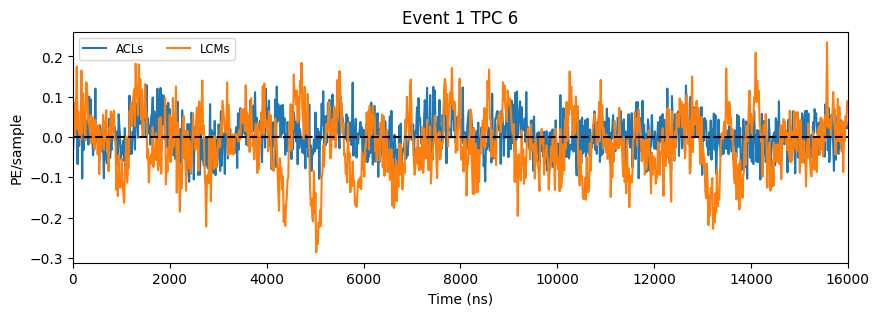

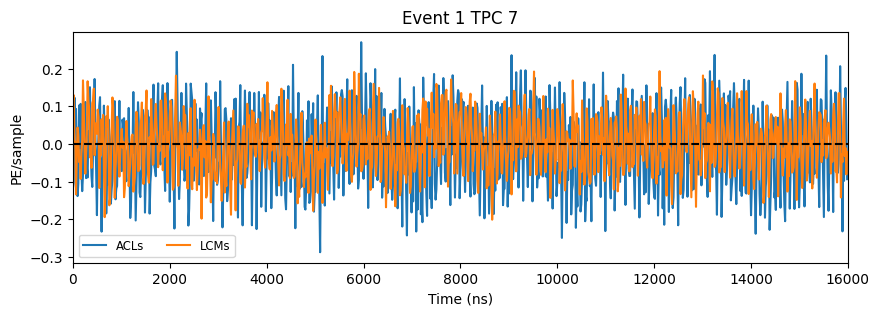

In [125]:
# example usage
evt = 1

# plot in pairs of waveforms (0,1), (2,3), ...
for i in range(0, 16, 2):
    indices = [i, i+1]
    tpc_num = indices[0] // 2
    plot_waveform_with_hit_finder(wvfms=ttype_wvfms[evt, indices, :],
                                  hits_list=ttype_hits[evt, indices, :],
                                  labels=['ACLs', 'LCMs'],
                                  title=f'Event {evt} TPC {tpc_num}')

In [126]:
# isolate [events,ttype] with 1 hit
events_with_hits = []
events_with_no_clipping = []
for evt in range(ttype_hits.shape[0]):
    for ttype in range(ttype_hits.shape[1]):
        n_hits = int(np.sum(ttype_hits[evt, ttype]))  # sum over samples
        if n_hits <= 0:
            continue
        # get (det, channel) index pairs for this ttype (shape: (N,2))
        indices = np.argwhere(ttype_sum[ttype])
        if indices.size == 0:
            # no channels for this ttype, skip
            continue
        # check for ADC saturation/clipping before accepting (guard against empty slice)
        max_val = light_wvfms[evt, indices[:, 0], indices[:, 1], :].max()
        if max_val > 8190:
            # skip clipped signals
            continue
        # record this event and ttype (only once per non-clipped hit)
        events_with_hits.append(evt)
        events_with_no_clipping.append((evt, ttype))

print(f'Found {len(events_with_no_clipping)} events and TType sum wvfms with hits')
print(f'Found {len(events_with_no_clipping)} events with no clipping in channels summed')

Found 198 events and TType sum wvfms with hits
Found 198 events with no clipping in channels summed


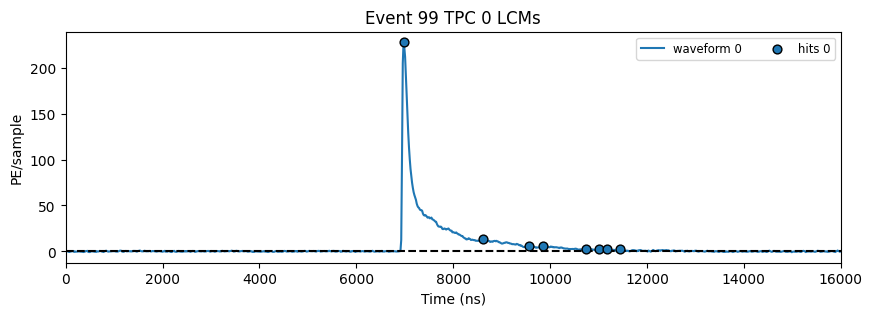

In [127]:
# order the hits by waveform integral (sum) in descending order
largest_first = sorted(events_with_no_clipping,
                       key=lambda evt_t: np.sum(ttype_wvfms[evt_t]),
                       reverse=True)

# order by height of the waveform
largest_first = sorted(events_with_no_clipping,
                       key=lambda evt_t: np.max(ttype_wvfms[evt_t]),
                       reverse=True)

# plot only those events and ttype channels
for i, (evt, ttype_idx) in enumerate(largest_first):
    # get TPC and ttype name
    tpc_num = ttype_idx // 2
    ttype_name = 'ACLs' if ttype_idx % 2 == 0 else 'LCMs'
    # ensure hits_list is a list matching the number of waveforms (1)
    plot_waveform_with_hit_finder(wvfms=ttype_wvfms[evt, ttype_idx],
                                  hits_list=[ttype_hits[evt, ttype_idx]],
                                  title=f'Event {evt} TPC {tpc_num} {ttype_name}')
    if i >= 0:
        break

In [128]:
# exponential functions with causal turn-on at t = mu

def single_exp_causal(t, A, tau, mu):
    """
    Causal exponential that turns on at t = mu.
    Avoids evaluating exp() for t < mu to prevent inf*0 -> NaN.
    """
    t = np.asarray(t, dtype=float)
    x = t - mu

    # Guard against tiny/zero tau
    tau = float(max(tau, 1e-12))

    y = np.zeros_like(t, dtype=float)
    m = x >= 0
    xm = x[m]

    # Only compute where x >= 0
    y[m] = (A / tau) * np.exp(-xm / tau)
    return y

def double_exp_causal(t, A1, tau1, A2, tau2, mu):
    """
    Causal sum of exponentials that turns on at t = mu.
    Avoids evaluating exp() for t < mu to prevent inf*0 -> NaN.
    """
    t = np.asarray(t, dtype=float)
    x = t - mu

    # Guard against tiny/zero taus
    tau1 = float(max(tau1, 1e-12))
    tau2 = float(max(tau2, 1e-12))

    y = np.zeros_like(t, dtype=float)
    m = x >= 0
    xm = x[m]

    # Only compute where x >= 0
    y[m] = (A1 / tau1) * np.exp(-xm / tau1) + (A2 / tau2) * np.exp(-xm / tau2)
    return y

def triple_exp_causal(t, A1, tau1, A2, tau2, A3, tau3, mu):
    """
    Causal sum of three exponentials that turns on at t = mu.
    Avoids evaluating exp() for t < mu to prevent inf*0 -> NaN.
    """
    t = np.asarray(t, dtype=float)
    x = t - mu

    # Guard against tiny/zero taus
    tau1 = float(max(tau1, 1e-12))
    tau2 = float(max(tau2, 1e-12))
    tau3 = float(max(tau3, 1e-12))

    y = np.zeros_like(t, dtype=float)
    m = x >= 0
    xm = x[m]

    # Only compute where x >= 0
    y[m] = (A1 / tau1) * np.exp(-xm / tau1) + (A2 / tau2) * np.exp(-xm / tau2) + (A3 / tau3) * np.exp(-xm / tau3)
    return y

/tmp/ipykernel_1391350/1312161812.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pulse_shape /= np.trapz(pulse_shape, dx=bin_width_ns)
/tmp/ipykernel_1391350/1312161812.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


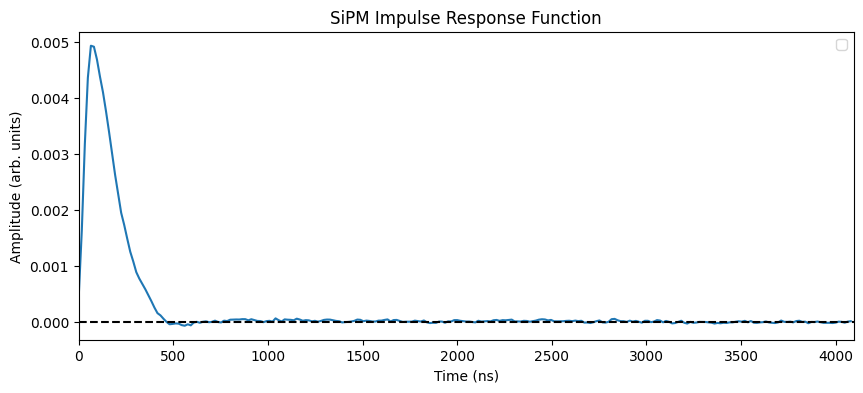

In [129]:
# load pulse shape file from larndsim/bin/sipm_impulse.npy
pulse_shape = np.load('/global/homes/j/jvmead/dune/larnd-sim/larndsim/bin/sipm_impulse.npy')
pulse_shape /= np.trapz(pulse_shape, dx=bin_width_ns)
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(pulse_shape)) * bin_width_ns, pulse_shape)
# add line at y=0
plt.axhline(0, color='black', linestyle='--')
# xlimits
plt.xlim(0, len(pulse_shape)*16)
plt.title('SiPM Impulse Response Function')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (arb. units)')
plt.legend()
plt.show()

# extend to 1000 samples (16000ns) long by concatenate with zeros
pulse_shape = np.concatenate([pulse_shape, np.zeros(1000 - len(pulse_shape))])

/tmp/ipykernel_1391350/512428581.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tpb_2exp /= np.trapz(tpb_2exp, dx=bin_width_ns)


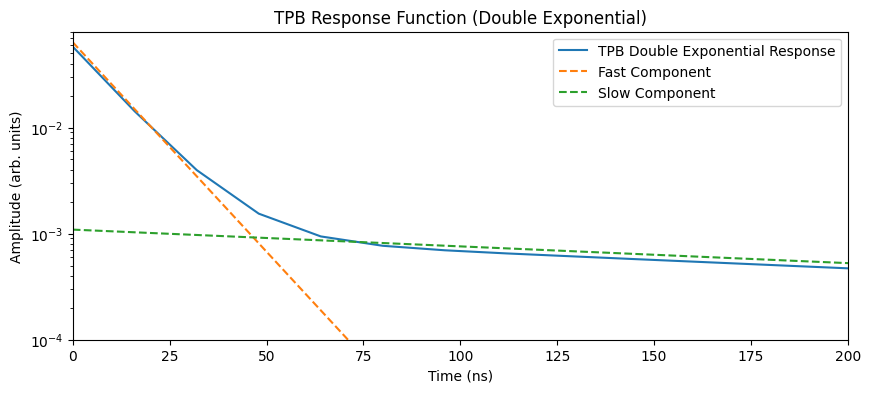

1000
1000


In [142]:
# model the TPB response as a double exponential with parameters
tpb_params = {
    "A1": 0.7,
    "tau1": 11.0,
    "A2": 0.3,
    "tau2": 275.0,
    "mu": 0,
}

tpb_2exp = double_exp_causal(
    t=time_bins,
    A1=tpb_params["A1"],
    tau1=tpb_params["tau1"],
    A2=tpb_params["A2"],
    tau2=tpb_params["tau2"],
    mu=tpb_params["mu"],
)
# normalize pulse shape to area of 1
tpb_2exp /= np.trapz(tpb_2exp, dx=bin_width_ns)

plt.figure(figsize=(10,4))
plt.plot(time_bins, tpb_2exp, label='TPB Double Exponential Response')
# show components
comp1 = (tpb_params["A1"]/tpb_params["tau1"])*np.exp(-np.maximum(0, time_bins-tpb_params["mu"])/tpb_params["tau1"])
comp2 = (tpb_params["A2"]/tpb_params["tau2"])*np.exp(-np.maximum(0, time_bins-tpb_params["mu"])/tpb_params["tau2"])
plt.plot(np.arange(len(tpb_2exp))*bin_width_ns, comp1, linestyle='--', label='Fast Component')
plt.plot(np.arange(len(tpb_2exp))*bin_width_ns, comp2, linestyle='--', label='Slow Component')
plt.title('TPB Response Function (Double Exponential)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (arb. units)')
plt.legend()
#plt.xscale('log')
plt.xlim(0, 200)
plt.yscale('log')
plt.ylim(1e-4, 0.08)
#plt.ylim(0, 0.08)
plt.show()

print(len(tpb_2exp))  # should be 1000
print(len(time_bins))  # should be 1000

/tmp/ipykernel_1391350/1611726920.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ej280_1exp /= np.trapz(ej280_1exp, dx=bin_width_ns)


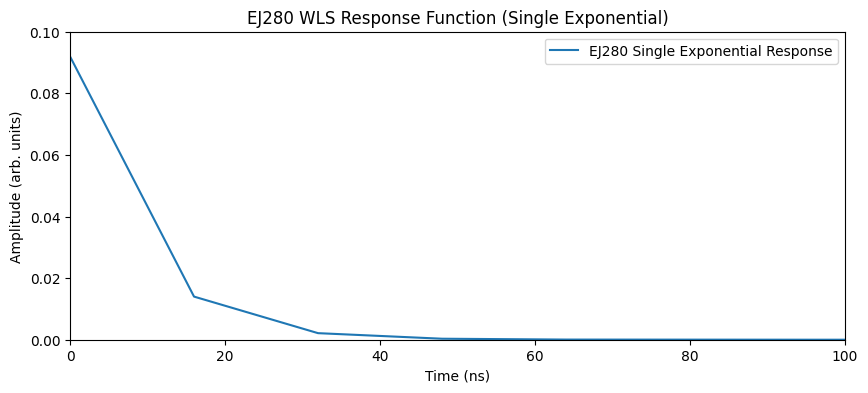

In [143]:
# model the EJ280 WLS as a single exponential with parameters
ej280_params = {
    "A": 1.0,
    "tau": 8.5,
    "mu": 0,
}

ej280_1exp = single_exp_causal(
    t=time_bins,
    A=ej280_params["A"],
    tau=ej280_params["tau"],
    mu=ej280_params["mu"],
)
# normalise to unit integral
ej280_1exp /= np.trapz(ej280_1exp, dx=bin_width_ns)

plt.figure(figsize=(10,4))
plt.plot(time_bins, ej280_1exp, label='EJ280 Single Exponential Response')
plt.title('EJ280 WLS Response Function (Single Exponential)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (arb. units)')
plt.legend()
#plt.xscale('log')
plt.xlim(0, 100)
#plt.yscale('log')
#plt.ylim(1e-3, 0.02)
plt.ylim(0, 0.1)
plt.show()

/tmp/ipykernel_1391350/199125798.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wls_lifetime /= np.trapz(wls_lifetime, dx=bin_width_ns)  # normalise
/tmp/ipykernel_1391350/199125798.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wls_spe_pulse /= np.trapz(wls_spe_pulse, dx=bin_width_ns)  # normalise


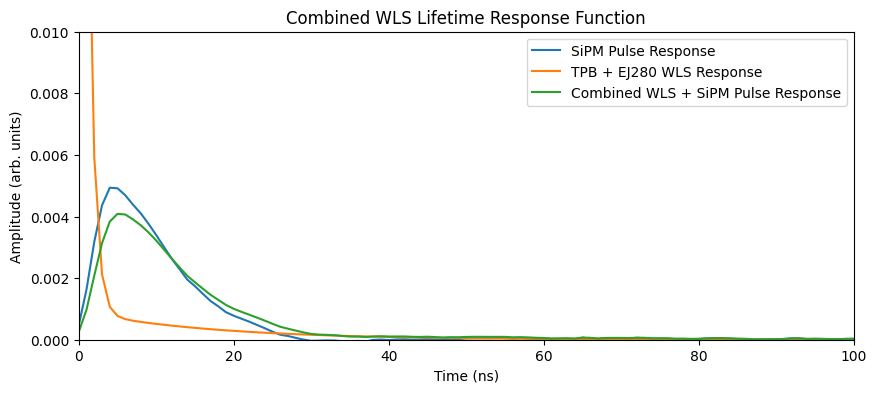

In [145]:
# combined shape from materials (except for time of flight, this should match look up tables)
from scipy.signal import fftconvolve

wls_lifetime = fftconvolve(tpb_2exp, ej280_1exp, mode='full')
wls_lifetime /= np.trapz(wls_lifetime, dx=bin_width_ns)  # normalise

wls_spe_pulse = fftconvolve(pulse_shape, wls_lifetime, mode='full')
wls_spe_pulse /= np.trapz(wls_spe_pulse, dx=bin_width_ns)  # normalise

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(pulse_shape)), pulse_shape, label='SiPM Pulse Response')
plt.plot(np.arange(len(wls_lifetime)), wls_lifetime, label='TPB + EJ280 WLS Response')
plt.plot(np.arange(len(wls_spe_pulse)), wls_spe_pulse, label='Combined WLS + SiPM Pulse Response')
plt.title('Combined WLS Lifetime Response Function')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (arb. units)')
plt.xlim(0, 100)
#plt.yscale('log')
#plt.ylim(1e-5, 0.2)
plt.ylim(0, 0.01)
plt.legend()

t_peak_ns = np.argmax(wls_spe_pulse) * bin_width_ns

In [133]:
# plotting function for waveform fit results

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, Any

def plot_waveform_fit(
    t_ns: np.ndarray,
    wvfm: np.ndarray,
    fitted: np.ndarray,
    residuals: np.ndarray,
    sigma_stat: np.ndarray,
    sigma_stat_eff: np.ndarray,
    sigma_fit: Optional[np.ndarray],
    popt_double: np.ndarray,
    evt: int,
    ttype_idx: int,
    n_samples: int,
    *,
    show: bool = True,
    savepath: Optional[str] = None,
) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes], Dict[str, Any]]:
    """
    Plot waveform (data) and fitted model with ±1σ bands on top, and pulls on bottom.

    Parameters
    ----------
    t_ns : array
        Time values [ns], same length as wvfm.
    wvfm : array
        Waveform (data) in PE/sample.
    fitted : array
        Fitted model evaluated on t_ns.
    residuals : array
        wvfm - fitted (same shape).
    sigma_stat : array
        Per-sample statistical uncertainty of data (for top band).
    sigma_stat_eff : array
        Effective per-sample uncertainty for pulls (denominator).
    sigma_fit : array or None
        Per-sample propagated model uncertainty. If None or all invalid, omitted.
    popt_double : array
        Fit parameter vector (expects index 4 to be the mean μ in ns, if available).
    evt : int
        Event id for the title.
    ttype_idx : int
        TType index for the title.
    n_samples : int
        Number of samples (used for fallback x-centering).
    show : bool, optional
        If True, calls plt.show() at the end. Default True.
    savepath : str or None, optional
        If given, saves the figure to this path.

    Returns
    -------
    fig, (ax1, ax2), stats : (Figure, (Axes, Axes), dict)
        The matplotlib figure/axes and a dict with chi2, ndof, reduced_chi2, rms_res.
    """
    # --- Plotting: top = data + model, bottom = pulls -----------------------
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]}
    )

    # Top: data and fitted model
    ax1.plot(t_ns, wvfm, label='Waveform (data)', color='C0', drawstyle='steps-post')
    ax1.plot(t_ns, fitted, label='Fitted model', color='C1', linestyle='--')
    ax1.set_ylabel('PE / sample')
    ax1.set_title(f'Event {evt} TType {ttype_idx} — Waveform and Fit')

    # ±1σ measurement (data) band drawn as per-sample step bands
    if np.any(np.isfinite(sigma_stat)):
        ax1.fill_between(
            t_ns, wvfm - sigma_stat, wvfm + sigma_stat,
            step='post', color='C0', alpha=0.2, edgecolor='none',
            label='±1σ (stat. uncertainty)'
        )

    # ±1σ fit-parameter propagated band
    if sigma_fit is not None and np.any(np.isfinite(sigma_fit)) and np.any(sigma_fit > 0):
        ax1.fill_between(
            t_ns, fitted - sigma_fit, fitted + sigma_fit,
            color='C1', alpha=0.25, edgecolor='none', label='±1σ (fit uncertainty)'
        )

    ax1.legend(fontsize='small', loc='upper right')
    ax1.set_ylim(min(-np.max(wvfm)*0.1, -np.max(fitted)*0.1),
                 max(np.max(wvfm)*1.1, np.max(fitted)*1.1))

    # Bottom: pulls = (data - model) / sigma_stat_eff
    pulls = residuals / sigma_stat_eff
    ax2.plot(t_ns, pulls, color='C0', label='Pulls', drawstyle='steps-post')
    ax2.axhline(0.0, color='C1', linestyle='--', label='Zero')

    # Plot ±1 band from data stat (in pull units)
    ax2.fill_between(
        t_ns, pulls-1.0, pulls+1.0, color='C0', alpha=0.2, step='post',
        edgecolor='none', label='±1σ (stat. uncertainty)'
    )

    # Fit-uncertainty band in pull units (if available)
    if sigma_fit is not None:
        band_lo = -sigma_fit / sigma_stat_eff
        band_hi = +sigma_fit / sigma_stat_eff
        band_lo = np.where(np.isfinite(band_lo), band_lo, np.nan)
        band_hi = np.where(np.isfinite(band_hi), band_hi, np.nan)
        ax2.fill_between(
            t_ns, band_lo, band_hi, color='C1', alpha=0.2, edgecolor='none',
            label='±1σ (fit uncertainty)'
        )

    ax2.set_ylabel('Pull')
    ax2.set_xlabel('Time (ns)')

    # --- Fit statistics annotations -----------------------------------------
    valid = np.isfinite(pulls)
    ndof = int(np.sum(valid)) - (len(popt_double) if popt_double is not None else 0) if np.any(valid) else 0
    chi2 = np.nansum((residuals[valid] / sigma_stat_eff[valid])**2) if np.any(valid) else np.nan
    reduced_chi2 = chi2 / ndof if ndof > 0 else np.nan
    rms_res = np.sqrt(np.nanmean(residuals**2))

    ax1.text(
        0.98, 0.15,
        f'χ²/ndf = {reduced_chi2:.3g}',
        transform=ax1.transAxes, fontsize='small', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )
    ax2.text(
        0.98, 0.25,
        f'RMS [PE/sample] = {rms_res:.3g}',
        transform=ax2.transAxes, fontsize='small', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    # --- Axis limits and layout ---------------------------------------------
    # Center x-limits around fitted mu if available, otherwise center on the waveform
    try:
        # popt_double[4] is already in units of ns (we fitted with t_ns)
        mu_fit_ns = float(popt_double[4])
        xlo, xhi = mu_fit_ns - 200.0, mu_fit_ns + 4000.0
    except Exception:
        mid = t_ns[n_samples // 2]
        xlo, xhi = mid - 200.0, mid + 4000.0

    #plt.xlim(xlo, xhi)

    # Symmetric pull y-limits with safe fallback
    max_pull = np.nanmax(np.abs(pulls))
    if np.isfinite(max_pull) and max_pull > 0:
        ax2.set_ylim(-1.1 * max_pull, 1.1 * max_pull)
    else:
        ax2.set_ylim(-3.0, 3.0)

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=150, bbox_inches='tight')
    if show:
        plt.show()

    stats = dict(chi2=chi2, ndof=ndof, reduced_chi2=reduced_chi2, rms_res=rms_res)
    return fig, (ax1, ax2), stats



In [134]:
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from scipy.ndimage import shift as frac_shift  # for fractional-sample shifts

def double_exp_spe_response(t, A1, tau1, A2, tau2, mu, pulse_shape):
    """
    Convolve causal double-exp with measured pulse shape.
    Uses a mask to avoid exp overflow in the causal builder.
    """
    t = np.asarray(t, dtype=float)
    dt = float(t[1] - t[0])  # sample spacing in same units as t (e.g., ns)
    pulse = np.asarray(pulse_shape, dtype=float)

    # Build source using mu directly in t-units
    src = double_exp_causal(t/dt, A1, tau1/dt, A2, tau2/dt, mu/dt)

    # Convolution and windowing
    y_full = fftconvolve(src, pulse, mode="full")
    y = y_full[:len(t)]

    # Optional sub-sample alignment (if mu not on the sampling grid)
    mu_samples = mu / dt
    frac = mu_samples - np.round(mu_samples)
    if frac != 0.0:
        y = frac_shift(y, shift=frac, mode="nearest", order=1)

    return y

# Handy wrapper for curve_fit
def double_exp_spe_response_fit(pulse_shape):
    return lambda t, A1, tau1, A2, tau2, mu: double_exp_spe_response(
        t, A1, tau1, A2, tau2, mu, pulse_shape
    )

Event 99 TType 1 total integral (PE): 87996.4 

Initial parameter guesses:
  A1 (PE): 13199.5
  tau1 (ns): 4
  A2 (PE): 74797
  tau2 (ns): 1200
  mu (ns): 6896



/tmp/ipykernel_1391350/3195846923.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A_total = float(np.trapz(wvfm, dx=bin_width_ns))         # keep as sum of samples in PE/sample units
/tmp/ipykernel_1391350/3195846923.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wvfm_int = np.trapz(wvfm, dx=bin_width_ns)
/tmp/ipykernel_1391350/3195846923.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  guess_int = np.trapz(initial_model, dx=bin_width_ns)


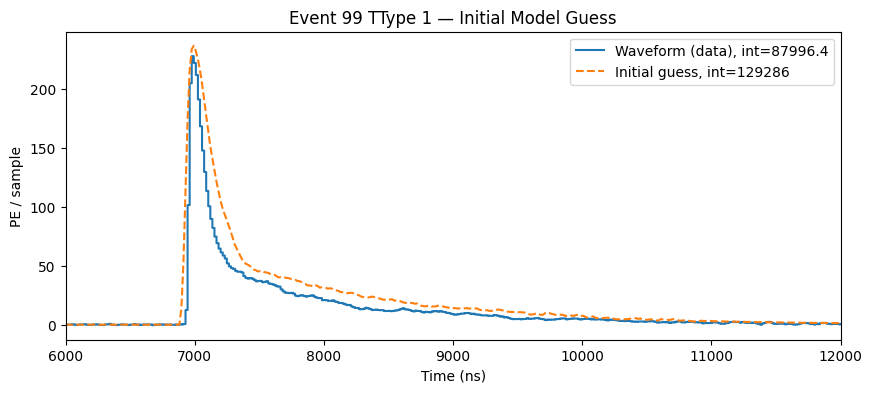

In [151]:
# --- Prepare waveform and time axes -----------------------------------------
evt, ttype_idx = largest_first[0]
wvfm = np.asarray(ttype_wvfms[evt, ttype_idx]).ravel()
n_samples = len(wvfm)

bin_width_ns = 16.0
t = np.arange(n_samples)              # samples (dimensionless)
t_ns = t * bin_width_ns               # time in ns (use this for the fit!)
wvfm_max_ns = n_samples * bin_width_ns

# Simple summary of the waveform
A_total = float(np.trapz(wvfm, dx=bin_width_ns))         # keep as sum of samples in PE/sample units
print(f'Event {evt} TType {ttype_idx} total integral (PE): {A_total:.6g} \n')

# --- Initial parameter guesses and bounds (ALL in ns for time-like params) ---
# mu guess: around the observed peak time (in ns)
mu_guess_ns = float(np.argmax(wvfm)) * bin_width_ns - t_peak_ns

# initial guesses
initial_guess = [
    0.15*A_total,   # A1 [PE]
    4.0,                       # tau1 [ns] (>= one bin is a good starting point)
    0.85*A_total,   # A2 [PE]
    1200.0,                     # tau2 [ns]
    mu_guess_ns,                # mu [ns]
]
bounds = (
    [   1.0,     1.0,     1.0,      1.0,          0.0],      # lower bounds (ns for taus/mu)
    [np.inf,  2000.0,  np.inf,   2000.0,  wvfm_max_ns]  # upper bounds
)

param_names = ['A1', 'tau1', 'A2', 'tau2', 'mu']

print("Initial parameter guesses:")
for name, val in zip(param_names, initial_guess):
    unit = "ns" if name in ('tau1', 'tau2', 'mu') else "PE"
    print(f"  {name} ({unit}): {float(val):.6g}")
print("")

# plot initial guess against data
initial_model = double_exp_spe_response(
    t_ns,
    initial_guess[0],
    initial_guess[1],
    initial_guess[2],
    initial_guess[3],
    initial_guess[4],
    wls_spe_pulse
)

plt.figure(figsize=(10,4))
wvfm_int = np.trapz(wvfm, dx=bin_width_ns)
guess_int = np.trapz(initial_model, dx=bin_width_ns)
plt.plot(t_ns, wvfm, label=f'Waveform (data), int={wvfm_int:.6g}', color='C0', drawstyle='steps-post')
plt.plot(t_ns, initial_model, label=f'Initial guess, int={guess_int:.6g}', color='C1', linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel('PE / sample')
plt.title(f'Event {evt} TType {ttype_idx} — Initial Model Guess')
plt.legend()
#plt.xlim(0, n_samples*bin_width_ns)
plt.xlim(6000, 12000)
plt.show()

In [152]:
# --- Build model that expects t in ns ---------------------------------------
# Ensure your model uses dt inferred from t (so ns is consistent end-to-end)
fmodel = double_exp_spe_response_fit(wls_spe_pulse)  # must accept (t_in_same_units, *params)

# --- Perform fit -------------------------------------------------------------
popt_double, pcov_double = curve_fit(
    fmodel,
    t_ns, wvfm,                              # <— xdata in ns to match tau/mu units
    p0=np.array(initial_guess, dtype=float),
    bounds=bounds,
    method='trf',
    maxfev=20000
)

perr_double = np.sqrt(np.diag(pcov_double)) if pcov_double is not None else np.full_like(popt_double, np.nan)


# --- Evaluate fitted model and residuals ------------------------------------
fitted = fmodel(t_ns, *popt_double)
residuals = wvfm - fitted

# --- Print fitted parameters (time-like already in ns) -----------------------
print("Fitted parameters:")
for name, val, err in zip(param_names, popt_double, perr_double):
    unit = "ns" if name in ('tau1', 'tau2', 'mu') else "PE"
    err = float(err) if np.isfinite(err) else np.nan
    print(f"  {name} ({unit}): {float(val):.6g}  ± {err:.6g}")

# --- Measurement/statistical uncertainty per sample --------------------------
pe_height = 0.12
N_obs = np.clip(wvfm / pe_height, 0.0, None)
sigma_stat = pe_height * np.sqrt(N_obs)
sigma_stat_eff = np.where((sigma_stat > 0) & np.isfinite(sigma_stat), sigma_stat, np.nan)

# --- Propagate fit-parameter uncertainty -------------------------------------
sigma_fit = None
try:
    p = np.asarray(popt_double, dtype=float)
    npar = p.size
    J = np.zeros((n_samples, npar), dtype=float)
    eps = np.sqrt(np.finfo(float).eps)
    for k in range(npar):
        h = eps * (abs(p[k]) + 1.0)
        p_plus = p.copy(); p_minus = p.copy()
        p_plus[k] += h; p_minus[k] -= h
        f_plus = fmodel(t_ns, *p_plus)
        f_minus = fmodel(t_ns, *p_minus)
        J[:, k] = (f_plus - f_minus) / (2.0 * h)

    if pcov_double is not None and np.all(np.isfinite(pcov_double)):
        var_fit = np.einsum('ij,jk,ik->i', J, pcov_double, J)
        var_fit = np.clip(var_fit, 0.0, None)
        sigma_fit = np.sqrt(var_fit)
except Exception:
    sigma_fit = None

Fitted parameters:
  A1 (PE): 13510.3  ± 171286
  tau1 (ns): 6.78354  ± 47.536
  A2 (PE): 48140.9  ± 1608.27
  tau2 (ns): 1316.26  ± 74.1563
  mu (ns): 6896  ± 0.00200151


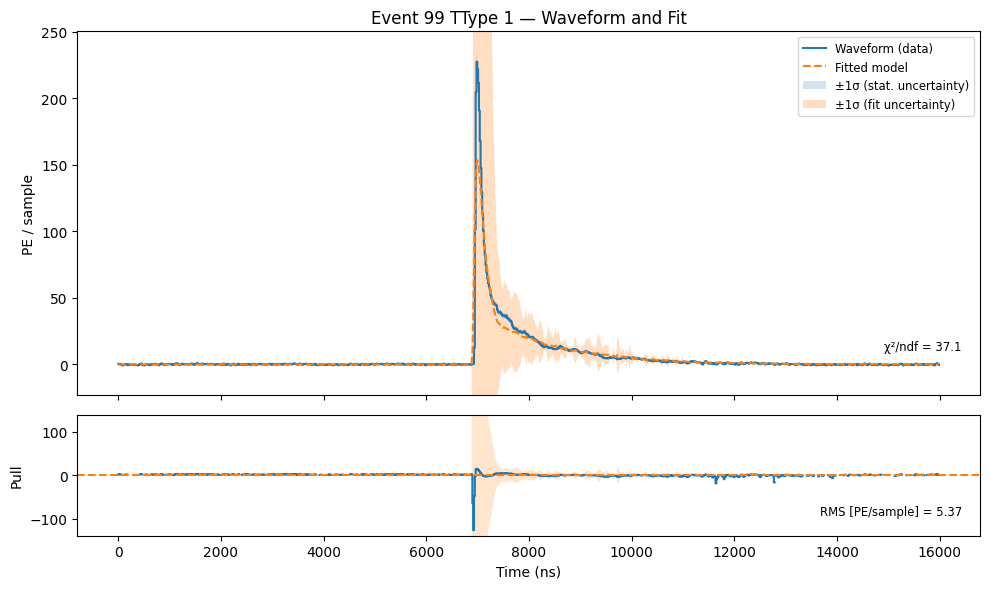

In [153]:
# Wrap plotting into a function for reuse: double fit version
fig, axes, stats = plot_waveform_fit(
    t_ns=t_ns,
    wvfm=wvfm,
    fitted=fitted,
    residuals=residuals,
    sigma_stat=sigma_stat,
    sigma_stat_eff=sigma_stat_eff,
    sigma_fit=sigma_fit,
    popt_double=popt_double,
    evt=evt,
    ttype_idx=ttype_idx,
    n_samples=n_samples,
    show=True,
    savepath=None
)

In [154]:
def triple_exp_spe_response(t, A1, tau1, A2, tau2, A3, tau3, mu, pulse_shape, allow_fractional_mu=True):
    """
    Convolve causal triple-exp with *already normalized* measured pulse shape.
    Keeps μ as a free parameter controlling the start time.
    """
    t = np.asarray(t)
    dt = t[1] - t[0]
    pulse = np.asarray(pulse_shape)

    # Causal triple exponential
    x = t - mu
    H = (x >= 0).astype(float)
    src = H * ((A1 / tau1) * np.exp(-x / tau1) +
               (A2 / tau2) * np.exp(-x / tau2) +
               (A3 / tau3) * np.exp(-x / tau3))

    y_full = fftconvolve(src, pulse, mode="full")
    y = y_full[:len(t)]  # same window as t

    if allow_fractional_mu:
        # Small fractional-sample refinement (smooth dependence on μ)
        frac = (mu / dt) - np.round(mu / dt)
        if frac != 0:
            y = frac_shift(y, shift=frac, mode="nearest", order=1)  # linear is robust

    return y

def triple_exp_spe_response_fit(pulse_shape):
    return lambda t, A1, tau1, A2, tau2, A3, tau3, mu: triple_exp_spe_response(
        t, A1, tau1, A2, tau2, A3, tau3, mu, pulse_shape
    )

Triple-exp initial guess:
  A1 (PE): 13510.3
  tau1 (ns): 6.78354
  A2 (PE): 48140.9
  tau2 (ns): 1316.26
  A3 (PE): 3082.56
  tau3 (ns): 6581.29
  mu (ns): 6896



/tmp/ipykernel_1391350/3563849249.py:13: RuntimeWarning: overflow encountered in exp
  src = H * ((A1 / tau1) * np.exp(-x / tau1) +
/tmp/ipykernel_1391350/3563849249.py:13: RuntimeWarning: overflow encountered in multiply
  src = H * ((A1 / tau1) * np.exp(-x / tau1) +
/tmp/ipykernel_1391350/3563849249.py:13: RuntimeWarning: invalid value encountered in multiply
  src = H * ((A1 / tau1) * np.exp(-x / tau1) +


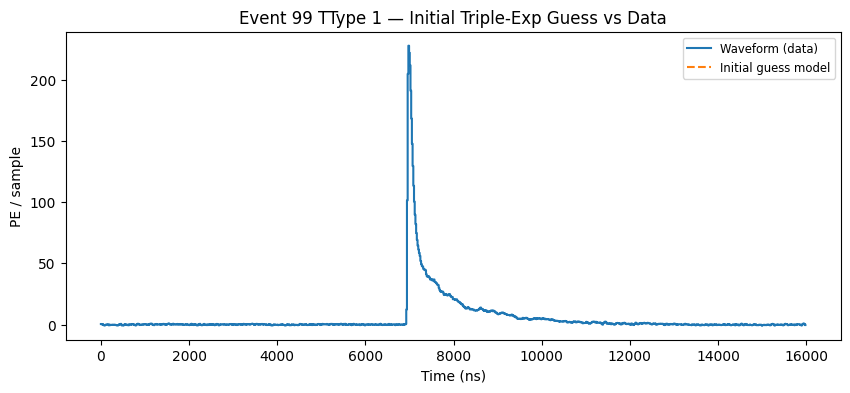

In [ ]:
# Convert double-exp result into a triple-exp fit (use double fit output as initial guess)
# Assumes: popt_double, pcov_double exist from prior double-exp fit; wvfm, bin_width_ns, n_samples, t_ns
# triple_exp_spe_response_fit(pulse_shape) must be available and accept (t_ns, *params)

# Parameter names for triple-exponential model
param_names_triple = ['A1', 'tau1', 'A2', 'tau2', 'A3', 'tau3', 'mu']

# Build triple-exp model
fmodel_triple = triple_exp_spe_response_fit(wls_spe_pulse)

param_names = ['A1', 'tau1', 'A2', 'tau2', 'mu']

print("Initial parameter guesses:")
for name, val in zip(param_names, initial_guess):
    unit = "ns" if name in ('tau1', 'tau2', 'mu') else "PE"
    print(f"  {name} ({unit}): {float(val):.6g}")
print("")

# plot initial guess against data
initial_model = double_exp_spe_response(
    t_ns,
    initial_guess[0],
    initial_guess[1],
    initial_guess[2],
    initial_guess[3],
    initial_guess[4],
    wls_spe_pulse
)

plt.figure(figsize=(10,4))
wvfm_int = np.trapz(wvfm, dx=bin_width_ns)
guess_int = np.trapz(initial_model, dx=bin_width_ns)
plt.plot(t_ns, wvfm, label=f'Waveform (data), int={wvfm_int:.6g}', color='C0', drawstyle='steps-post')
plt.plot(t_ns, initial_model, label=f'Initial guess, int={guess_int:.6g}', color='C1', linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel('PE / sample')
plt.title(f'Event {evt} TType {ttype_idx} — Initial Model Guess')
plt.legend()
#plt.xlim(0, n_samples*bin_width_ns)
plt.xlim(6000, 12000)
plt.show()

In [140]:
# Run fit (robust to failures)
popt_triple, pcov_triple = None, None
try:
  popt_triple, pcov_triple = curve_fit(
    fmodel_triple,
    t_ns, wvfm,
    p0=p0_triple,
    bounds=bounds_triple,
    method='trf',
    maxfev=30000
  )
except Exception as e:
  print("Triple-exp fit failed:", e)

# If fit succeeded, evaluate and print
if popt_triple is not None:
  perr_triple = np.sqrt(np.diag(pcov_triple)) if pcov_triple is not None else np.full_like(popt_triple, np.nan)

  fitted_triple = fmodel_triple(t_ns, *popt_triple)
  residuals_triple = wvfm - fitted_triple

  print("Fitted triple-exp parameters:")
  for name, val, err in zip(param_names_triple, popt_triple, perr_triple):
    unit = "ns" if name in ('tau1','tau2','tau3','mu') else "PE"
    err = float(err) if np.isfinite(err) else np.nan
    print(f"  {name} ({unit}): {float(val):.6g}  ± {err:.6g}")
  print("")

  # Propagate parameter covariance -> per-sample uncertainty of the model prediction
  sigma_fit_triple = None
  try:
    p = np.asarray(popt_triple, dtype=float)
    npar = p.size
    J = np.zeros((n_samples, npar), dtype=float)
    eps = np.sqrt(np.finfo(float).eps)
    for k in range(npar):
      h = eps * (abs(p[k]) + 1.0)
      p_plus = p.copy(); p_minus = p.copy()
      p_plus[k] += h; p_minus[k] -= h
      f_plus = fmodel_triple(t_ns, *p_plus)
      f_minus = fmodel_triple(t_ns, *p_minus)
      J[:, k] = (f_plus - f_minus) / (2.0 * h)

    if pcov_triple is not None and np.all(np.isfinite(pcov_triple)):
      var_fit = np.einsum('ij,jk,ik->i', J, pcov_triple, J)
      var_fit = np.clip(var_fit, 0.0, None)
      sigma_fit_triple = np.sqrt(var_fit)
  except Exception:
    sigma_fit_triple = None

Fitted triple-exp parameters:
  A1 (PE): 30508.5  ± 373314
  tau1 (ns): 12.6229  ± 125.451
  A2 (PE): 90360  ± 1.07973e+06
  tau2 (ns): 1001.52  ± 6707.59
  A3 (PE): 20406.7  ± 949123
  tau3 (ns): 3398.79  ± 187322
  mu (ns): 6896  ± 93.9819



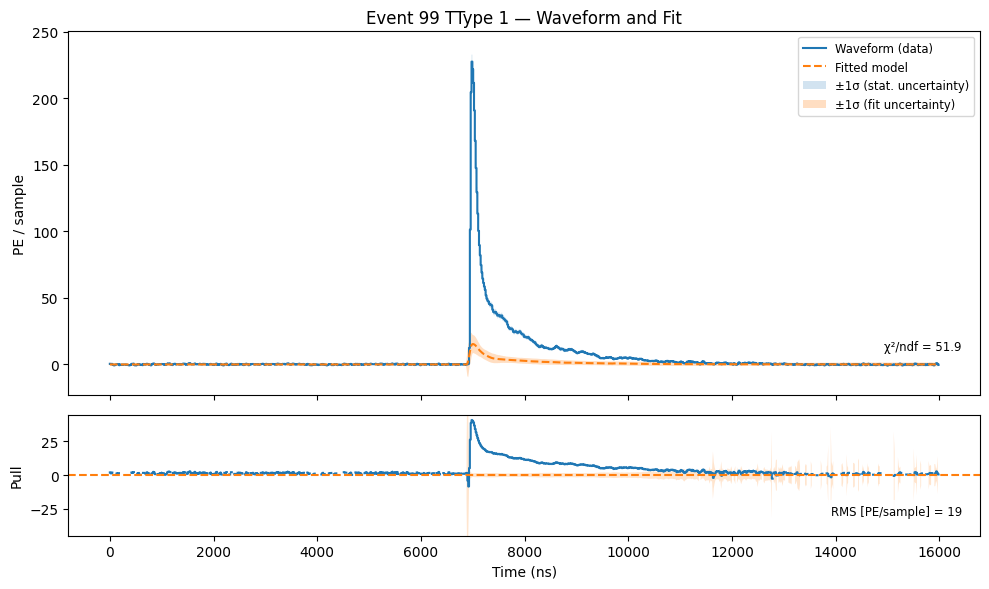

In [141]:
# Wrap plotting into a function for reuse: triple fit version
fig, axes, stats = plot_waveform_fit(
    t_ns, wvfm, fitted_triple, residuals_triple,
    sigma_stat, sigma_stat_eff, sigma_fit_triple,
    popt_triple, evt, ttype_idx, n_samples,
    savepath=None, show=True
)